# Validation tests for DC2 1.2i/p single visit catalogs

**Author:** Javier Sánchez

**Date last run:** Apr-21-2019

**Goals:** Make astrometry and photometry quality checks on 1.2i/p single-epoch data

All the plots in this notebook can be made with 1.2p as well. You just have to change

`gc_data = SingleVisitCatalog(repo=data_imsim, filter_band='r', visit=197425, detector=None)`

To:

`gc_data = SingleVisitCatalog(repo=data_phosim, filter_band='r', visit=197425, detector=None)`

** Note ** Temporary fix while GCRCatalogs is updated...

In [1]:
import sys
sys.path.insert(0, '/global/homes/j/jsanch87/gcr-catalogs/')
import GCRCatalogs

/global/homes/j/jsanch87/gcr-catalogs/GCRCatalogs/__init__.py


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import GCR
#import GCRCatalogs
import healpy as hp
import pandas as pd
from scipy.stats import binned_statistic

`GCRCatalogs` contains a wrapper of the Butler in the `SingleVisitCatalog` class that is very convenient to query all detectors for a single visit or all visits of a given filter.

In [4]:
from GCRCatalogs.butler_interface import SingleVisitCatalog

We use sklearn to build the catalog matcher

In [5]:
from sklearn.neighbors import KDTree

We check the directory where the 1.2i data calexps live

In [6]:
data_imsim = '/global/cscratch1/sd/desc/DC2/data/Run1.2i_globus_in2p3_20181217/w_2018_39/rerun/281118'

In [139]:
data_phosim = '/global/cscratch1/sd/desc/DC2/data/Run1.2p_v4/w_2018_39/rerun/calexp-v4'

Below are the columns that we are going to use in our validation tests

In [7]:
columns = ['coord_ra', # ra coordinate (in radians)
           'coord_dec', # dec coordinate (in radians)
           'calib_photometry_used', # Has this object been used for photometric calibrations?
           'calib_astrometry_used', # Has this object been used for astrometric calibrations?
           'base_ClassificationExtendedness_value', # This is a basic star/galaxy separation flag more on Bosch et al 2018
           'ext_shapeHSM_HsmShapeRegauss_e1', # e1 using GalSim's HSM
           'ext_shapeHSM_HsmShapeRegauss_e2', # e2 using GalSim's HSM
           'base_SdssShape_xx', # xx moment using SDSS algorithm
           'base_SdssShape_xy', # xy moment using SDSS algorithm
           'base_SdssShape_yy', # yy moment using SDSS algorithm
           'base_SdssShape_psf_xx', # xx moment of the PSF in the position of this object using SDSS algorithm
           'base_SdssShape_psf_xy', # xy as above
           'base_SdssShape_psf_yy', # yy as above
           'base_PsfFlux_instFlux', # PSF-flux
           'base_PsfFlux_instFluxErr', # PSF-flux error
           'ext_photometryKron_KronFlux_instFlux', # Kron flux
           'ext_photometryKron_KronFlux_instFluxErr', # Kron flux uncertainty
           'ext_photometryKron_KronFlux_mag', # Kron magnitude
           'ext_photometryKron_KronFlux_magErr', # Kron magnitude error
           'base_PsfFlux_mag', # magnitude computed in a PSF magnitude (derived from base_PsfFlux_instFlux with the corresponding zeropoint)
           'base_PsfFlux_magErr', # corresponding error to the above magnitude
]

Now we instantiate a galaxy catalog of the class `SingleVisitCatalog` from `gcr-catalogs`. This class allows for getting all single visits for a given filter. If you further specify the visit number, it will query all detectors for you. Finally, if you want to query a given detector, you can specify it via the detector option (the way to specify it is using the detector number rather than the typical sensor/raft). We choose visit 197425.

In [140]:
gc_data = SingleVisitCatalog(repo=data_phosim, filter_band='r', visit=197425, detector=None)

And we also get the corresponding truth catalog

In [9]:
#gc = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')
gc = GCRCatalogs.load_catalog('dc2_reference_run1.2')

We can check the quantities that these catalogs contain by listing their quantities:

In [10]:
gc.list_all_quantities()

['sigma_dec',
 'ra',
 'mag_u_unsmeared',
 'mag_u_lsst',
 'mag_g',
 'mag_r_unsmeared',
 'mag_r_lsst',
 'ra_unsmeared',
 'mag_u',
 'dec',
 'mag_z_lsst',
 'is_resolved',
 'mag_i',
 'mag_g_unsmeared',
 'mag_i_lsst',
 'is_agn',
 'object_id',
 'mag_g_lsst',
 'mag_r',
 'mag_z_unsmeared',
 'mag_i_unsmeared',
 'dec_unsmeared',
 'mag_y_unsmeared',
 'sigma_ra',
 'mag_z',
 'mag_y_lsst',
 'mag_y']

We will load position and magnitudes from the benchmark catalog(s). Since it is unlikely that in a single visit we detect objects fainter than $r = 27$ we will filter them out so the query is faster.

In [12]:
# Uncomment the top row (and comment the bottom row) if you want to use the truth catalog instead of the reference catalog
#data = gc.get_quantities(['ra','dec','mag_true_u','mag_true_g','mag_true_r','mag_true_i','mag_true_z','mag_true_y','object_id','star','sprinkled'], , filters=['mag_r_lsst < 27'])
data = gc.get_quantities(['ra','dec','mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst','object_id','is_resolved'], filters=['mag_r_lsst < 27'])

/global/homes/j/jsanch87/gcr-catalogs/GCRCatalogs/reference_catalog.py:67: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v3_fov4.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


In [13]:
# We create some columns so we can mix and match the catalogs
data['star']=~data['is_resolved']
for band in ['u','g','r','i','z','y']:
    data['mag_true_%s' %band] = data['mag_%s_lsst' %band]

Now we are going to load 189 sensor-visits using the butler. We just choose a subset of the columns, you can check which columns are available in the catalog using `gc_data.list_all_native_quantities()` and `gc_data.list_all_quantities()`.

The catalogs contain the parent objects (before deblending) and the children object (after deblending), thus, it is important to filter out the objects with `deblend_nChild!=0`.

In [141]:
data_im = gc_data.get_quantities(columns, filters=['deblend_nChild == 0'])

Let's take a look at our data! (we plot only 10% of the data points)

Text(0,0.5,'DEC [deg]')

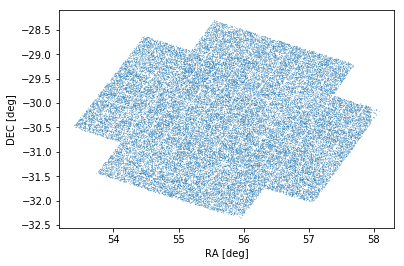

In [142]:
plt.scatter(np.degrees(data_im['coord_ra'][::10]),np.degrees(data_im['coord_dec'][::10]),s=0.01)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

We are going to create a map with the detected objects so we discard  objects in the truth catalog that lie outside of the area that we observe. 
This is just an approximation but it should be enough for this tutorial. Ideally, we would use the WCS of each sensor/single-visit and select objects in the truth catalog that lie within the boundaries of each sensor/visit.

In [98]:
import healpy as hp
pixnums = hp.ang2pix(4096, np.pi/2-data_im['coord_dec'], data_im['coord_ra'])
pixnums_true = hp.ang2pix(4096, np.pi/2.-np.radians(data['dec']), np.radians(data['ra']))
in_footprint = np.in1d(pixnums_true, np.unique(pixnums))

In [99]:
# We only use objects in the true catalog that lie within the FOV 
ra_true = data['ra'][in_footprint]
dec_true = data['dec'][in_footprint]
mag_true = data['mag_r_lsst'][in_footprint]

Now that we have loaded the input and output catalogs, we need to relate them. We check the neighbors within a certain radius and choose the closest match in magnitude

In [100]:
def spatial_closest_mag_1band(ra_data,dec_data,mag_data,
                              ra_true,dec_true,mag_true,true_id,
                              rmax=3,max_deltamag=1.):
    """
    Function to return the closest match in magnitude within a user-defined radius within certain
    magnitude difference.
    
    ***Caveats***: This method uses small angle approximation sin(theta)
    ~ theta for the declination axis. This should be fine to find the closest
    neighbor. This method does not use any weighting.
    
    Args:
    -----
    
    ra_data: Right ascension of the measured objects (degrees).
    dec_data: Declination of the measured objects (degrees).
    mag_data: Measured magnitude of the objects.
    ra_true: Right ascension of the true catalog (degrees).
    dec_true: Declination of the true catalog (degrees).
    mag_true: True magnitude of the true catalog.
    true_id: Array of IDs in the true catalog.
    rmax: Maximum distance in number of pixels to perform the query.
    max_deltamag: Maximum magnitude difference for the match to be good.
    
    Returns:
    --------
    
    dist: Distance to the closest neighbor in the true catalog. If inputs are
    in degrees, the returned distance is in arcseconds.
    true_id: ID in the true catalog for the closest match.
    matched: True if matched, False if not matched.
    """
    X = np.zeros((len(ra_true),2))
    X[:,0] = ra_true
    X[:,1] = dec_true
    tree = KDTree(X,metric='euclidean')
    Y = np.zeros((len(ra_data),2))
    Y[:,0] = ra_data
    Y[:,1] = dec_data
    ind,dist= tree.query_radius(Y,r=rmax*0.2/3600,return_distance=True)
    matched = np.zeros(len(ind),dtype=bool)
    ids = np.zeros(len(ind),dtype=true_id.dtype)
    dist_out = np.zeros(len(ind))
    for i, ilist in enumerate(ind):
        if len(ilist)>0:
            dmag = np.fabs(mag_true[ilist]-mag_data[i])
            good_ind = np.argmin(dmag)
            ids[i]=true_id[ilist[good_ind]]
            dist_out[i]=dist[i][good_ind]
            if np.min(dmag)<max_deltamag:
                matched[i]=True
            else:
                matched[i]=False
        else:
            ids[i]=-99
            matched[i]=False
            dist_out[i]=-99.
    return dist_out*3600., ids,matched

In [101]:
dd, ind_mag, matched = spatial_closest_mag_1band(np.degrees(data_im['coord_ra']),
                                                 np.degrees(data_im['coord_dec']),
                                                 data_im['ext_photometryKron_KronFlux_mag'],
                                                 ra_true,
                                                 dec_true,
                                                 mag_true,
                                                 np.arange(len(ra_true)),
                                                 rmax=5,max_deltamag=1)

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


The `calexps` contain some objects used for the photometric calibration. We are going to check the photometric residuals in these objects (`'calib_photometry_used'==True`).

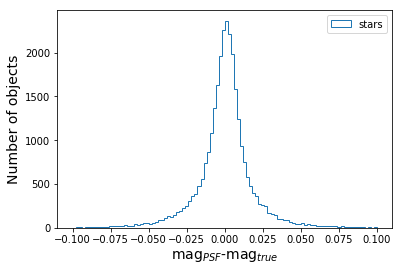

In [102]:
isphoto = data_im['calib_photometry_used']
mag_psf = data_im['base_PsfFlux_mag']
data_mask = (matched) & (isphoto) & (data['star'][in_footprint][ind_mag]) # We want objects used for photometric calibration matched to stars
plt.hist(mag_psf[data_mask] - mag_true[ind_mag][data_mask],
        range=(-0.1,0.1),bins=100, histtype='step',label='stars')
plt.xlabel('mag$_{PSF}$-mag$_{true}$',fontsize=14)
plt.ylabel('Number of objects',fontsize=14)
plt.legend(loc='best');

The same happens for astrometry. We check the astrometric residuals for objects that have `calib_astrometry_used==True`.

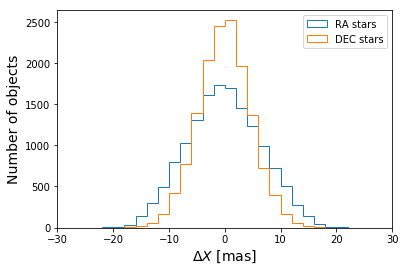

In [103]:
isastro = data_im['calib_astrometry_used']
data_mask = (matched) & (isastro) & (data['star'][in_footprint][ind_mag]) # We want objects used for astrometric calibration and matched to stars
plt.hist(3600000*np.cos(data_im['coord_dec'][data_mask])*(np.degrees(data_im['coord_ra'])[data_mask]
                  -ra_true[ind_mag][data_mask]),range=(-200,200),bins=200, histtype='step',label='RA stars')
plt.hist(3600000*(np.degrees(data_im['coord_dec'])[data_mask]
                  -dec_true[ind_mag][data_mask]),range=(-200,200),bins=200, histtype='step',label='DEC stars')
plt.xlim(-30,30)
plt.xlabel(r'$\Delta X $ [mas]',fontsize=14)
plt.ylabel('Number of objects',fontsize=14)
plt.legend(loc='best');

Now, we are going to check the photometry for all detected objects matched to stars.

In [104]:
mask_mag = (np.isnan(mag_psf)==False) & (matched) & (data['star'][in_footprint][ind_mag])

In [105]:
good_true = (data['star'][in_footprint]) 

In [107]:
delta_mag = data_im['base_PsfFlux_mag'][mask_mag]-mag_true[ind_mag][mask_mag] # We check the magnitude difference

mean_im, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], delta_mag, range=(10,30), bins=50, statistic='median')
std_im, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], delta_mag ,range=(10,30), bins=50, statistic='std')
n_im, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], delta_mag, range=(10,30), bins=50, statistic='count')
n_true, be, _ = binned_statistic(mag_true[good_true], mag_true[good_true], range=(10,30), bins=50, statistic='count')

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


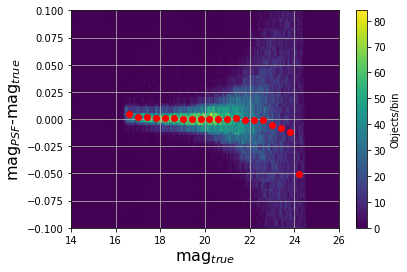

In [108]:
plt.errorbar(0.5*be[1:]+0.5*be[:-1], mean_im,std_im/np.sqrt(n_im), fmt='o', color='red')
plt.hexbin(mag_true[ind_mag][mask_mag], delta_mag, gridsize=200, extent=[14,26,-0.5,0.5])
plt.xlabel('mag$_{true}$', fontsize=16)
plt.ylabel('mag$_{PSF}$-mag$_{true}$', fontsize=16)
plt.colorbar(label='Objects/bin')
plt.grid()
plt.ylim(-0.1,0.1)
plt.xlim(14,26);

Now, we are going to check the sources' sizes as a function of their magnitude and look for the presence of brighter-fatter effect.

In [109]:
T = (data_im['base_SdssShape_xx']+data_im['base_SdssShape_yy'])*0.2**2 # Trace of the second order moments in arcseconds^2 (that's why we multiply times 0.2)
mean_im_t, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], T[mask_mag], range=(10,30), bins=50, statistic='median')
std_im_t, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], T[mask_mag], range=(10,30), bins=50, statistic='std')
n_im_t, be, _ = binned_statistic(mag_true[ind_mag][mask_mag], T[mask_mag], range=(10,30), bins=50, statistic='count')

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


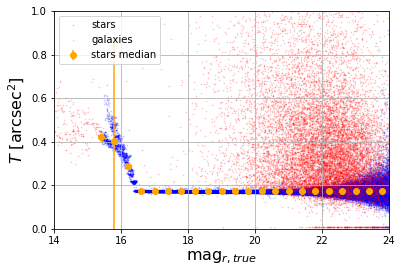

In [110]:
plt.scatter(mag_true[ind_mag][mask_mag], T[mask_mag], c='b', s=0.4, alpha=0.2, label='stars')
# Let's only plot 10% of the galaxies
plt.scatter(mag_true[ind_mag][~mask_mag][::10],T[~mask_mag][::10], c='r', s=0.4, alpha=0.2, label='galaxies')
plt.errorbar(0.5*be[1:]+0.5*be[:-1], mean_im_t, std_im_t/np.sqrt(n_im_t), fmt='o', c='orange', label='stars median')
plt.ylabel('$T$ [arcsec$^{2}$]',fontsize=16)
plt.xlabel('mag$_{r,true}$',fontsize=16)
plt.grid()
plt.ylim(0.,1.)
plt.xlim(14,24)
plt.legend(loc='best')

Let's zoom in!

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(-0.01, 0.01)

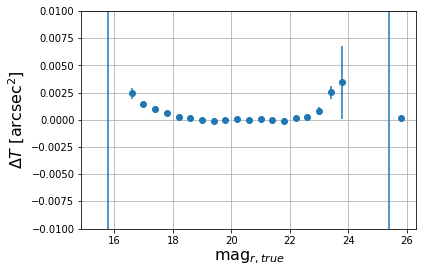

In [111]:
bc = 0.5*(be[1:]+be[:-1])
plt.errorbar(bc,mean_im_t-np.nanmean(mean_im_t[(bc>20) & (bc<22)]),std_im_t/np.sqrt(n_im_t),fmt='o')
plt.ylabel(r'$\Delta T$ [arcsec$^{2}$]',fontsize=16)
plt.xlabel('mag$_{r,true}$',fontsize=16)
plt.grid()
plt.ylim(-0.01,0.01)

**We can see the Brighter-fatter effect!!**

A very useful QA plot is to check the detection efficiency for stars as a function of magnitude.

**Note:** We compare the number of detected/matched stars with the number of input objects in our selection, i.e., it depends on how we select the objects in the truth catalog that are in the footprint. For accurate results, we need to check the WCS of each calexp or use very high resolution masks.

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


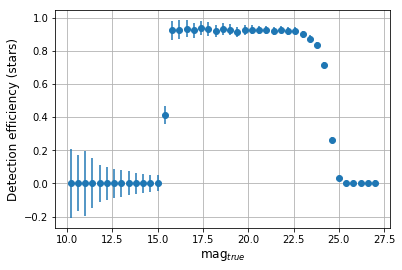

In [112]:
plt.errorbar(0.5*(be[1:]+be[:-1]),1.0*n_im/n_true,np.sqrt(n_im+n_true)/n_true,fmt='o')
plt.xlabel('mag$_{true}$',fontsize=12)
plt.ylabel('Detection efficiency (stars)',fontsize=12)
plt.grid()

Another useful QA plot is to construct a depth map:

In [130]:
def get_depth_map(ra, dec, mags, snr, nside=128, min_snr=4, max_snr=6):
    """ Routine to quickly compute the depth given position, magnitude and SNR
    
    Args:
    -----
    ra: ndarray (float),
        RA of the detected objects in degrees
    dec: ndarray (float),
        Dec of the detected objects in degrees
    mags: ndarray (float),
        Magnitude of the detected objects 
    snr: ndarray (float).
        Array containing the SNR of the detected objects
    
    """
    # Filter NaNs and select objects in the range of SNR that we care about to speed things up
    good = (~np.isnan(ra)) & (~np.isnan(dec)) & (snr >= min_snr) & (snr <= max_snr) 
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    map_out = np.zeros(12*nside**2)
    for px in np.unique(pix_nums):
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            map_out[px]=np.nanmedian(mags[good][mask]) 
        else:
            map_out[px]=0.
    return map_out

In [126]:
def make_hp_map(ra,dec,nside=128):
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    pix_counts = np.bincount(pix_nums,minlength=12*nside**2)
    return pix_counts

In [134]:
snr_array = (data_im['base_PsfFlux_instFlux']/ data_im['base_PsfFlux_instFluxErr'])[~np.isnan(data_im['base_PsfFlux_mag'])]
test_map = get_depth_map(np.degrees(data_im['coord_ra'])[~np.isnan(data_im['base_PsfFlux_mag'])],
                         np.degrees(data_im['coord_dec'])[~np.isnan(data_im['base_PsfFlux_mag'])],
                         data_im['base_PsfFlux_mag'][~np.isnan(data_im['base_PsfFlux_mag'])],
                         snr_array,
                         nside=1024)

We can check the spatial distribution...

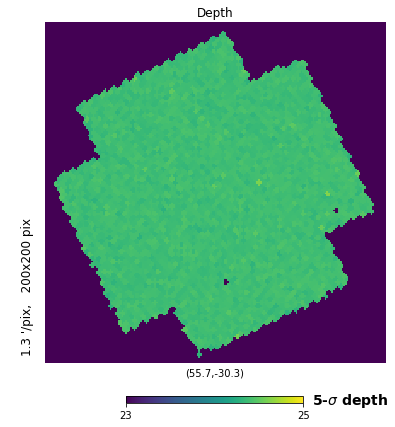

In [135]:
hp.gnomview(test_map, rot=(55.7, -30.3), title='Depth', reso=1.3, min=23, max=25, unit=r'5-$\sigma$ depth')

And the overall 1D distribution

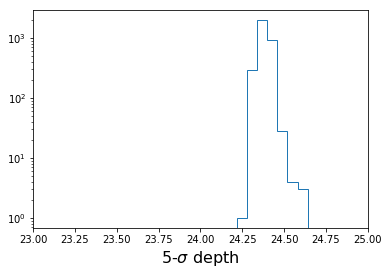

In [138]:
plt.hist(test_map[test_map>0],range=(22,28),bins=100, histtype='step')
plt.xlabel(r'5-$\sigma$ depth', fontsize=16)
plt.xlim(23, 25)
plt.yscale('log');